In [830]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

%matplotlib inline

In [831]:
backend = AerSimulator()

In [832]:
N_QUBITS = 6

# Randomly mark values
size = np.random.randint(1, N_QUBITS + 1)
MARKED_LIST = np.random.choice(range(2**N_QUBITS), size, replace=False).tolist()

In [833]:
def initialize_superposition(qc: QuantumCircuit, qr: QuantumRegister):
    """
    Initialize the quantum register in a superposition state.
    This function applies Hadamard gates to all qubits in the quantum register.
    """
    qc.h(qr)

In [834]:
qr_data = QuantumRegister(N_QUBITS, name='q')
cr_data = ClassicalRegister(N_QUBITS, name='cr')
quantum_circuit = QuantumCircuit(qr_data, cr_data) # Grover's curcuit

initialize_superposition(quantum_circuit, qr_data)

quantum_circuit.draw()

┌───┐
 q_0: ┤ H ├
      ├───┤
 q_1: ┤ H ├
      ├───┤
 q_2: ┤ H ├
      ├───┤
 q_3: ┤ H ├
      ├───┤
 q_4: ┤ H ├
      ├───┤
 q_5: ┤ H ├
      └───┘
cr: 6/═════

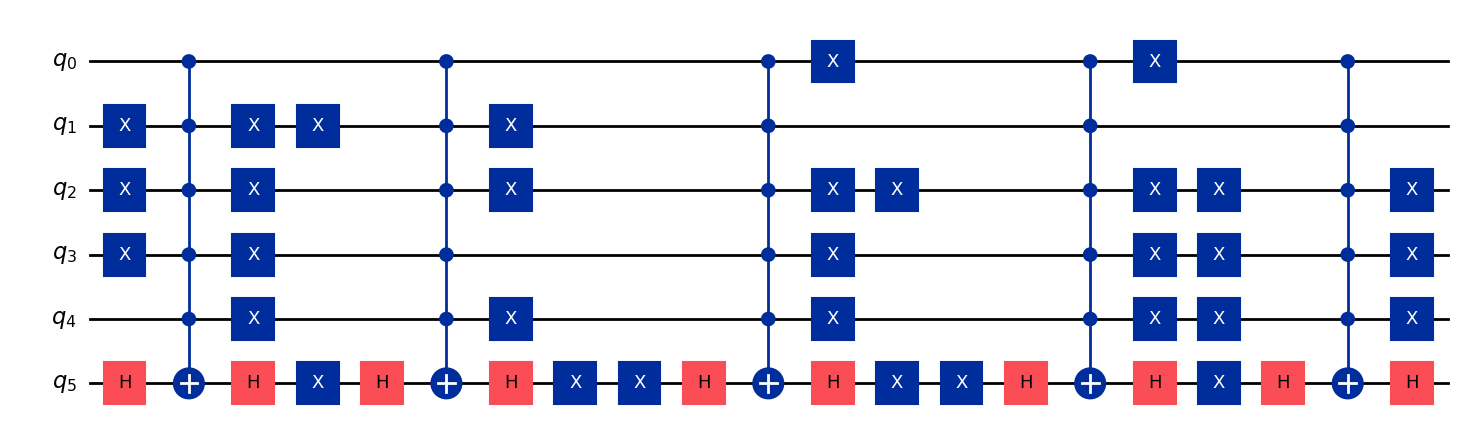

In [835]:
# Setup Oracle
def create_oracle(qr: QuantumRegister) -> QuantumCircuit:
    """
    Create the oracle for Grover's algorithm.
    The oracle marks the states that are part of the MARKED_LIST by flipping the sign of their amplitudes.
    """
    oracle = QuantumCircuit(qr, name='oracle')
    for m in MARKED_LIST:
        bits_m = format(m, f'0{N_QUBITS}b')
        
        for idx, bit in enumerate(bits_m):
            if bit == '0':
                oracle.x(qr[idx])
        oracle.h(qr[N_QUBITS - 1])
        oracle.mcx(list(qr[: N_QUBITS - 1]), qr[N_QUBITS - 1])
        oracle.h(qr[N_QUBITS - 1])
        for idx, bit in enumerate(bits_m):
            if bit == '0':
                oracle.x(qr[idx])

    oracle.draw('mpl')
    oracle = oracle.to_gate()
  
    return oracle

oracle = create_oracle(qr_data)

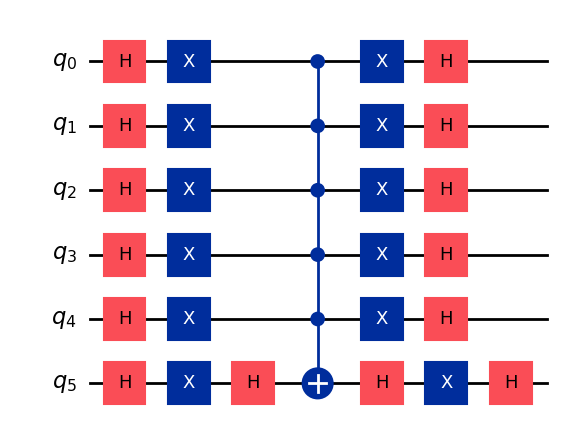

In [836]:
# Defuser
def create_diffuser(qr: QuantumRegister, num_bits: int) -> QuantumCircuit:
    """
    Create a diffuser circuit for Grover's algorithm.
    The diffuser amplifies the probability of the marked states.
    """
    diffuser = QuantumCircuit(qr, name='diffuser')
    diffuser.h(qr)
    diffuser.x(qr)

    diffuser.h(qr[num_bits - 1])
    diffuser.mcx(list(qr[: num_bits - 1]), qr[num_bits - 1])
    diffuser.h(qr[num_bits - 1])
    
    diffuser.x(qr)
    diffuser.h(qr)

    diffuser.draw('mpl')
    return diffuser.to_gate()

diffuser = create_diffuser(qr_data, N_QUBITS)

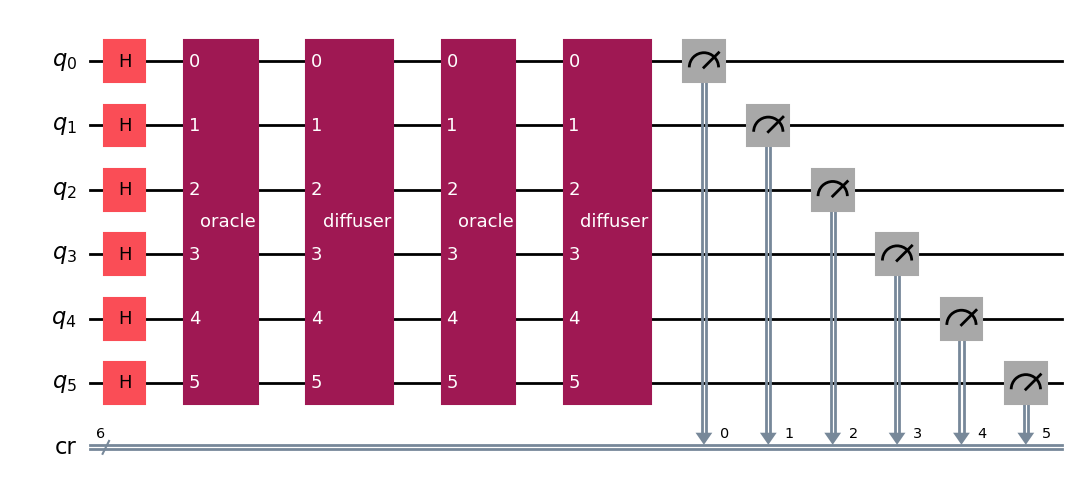

In [837]:
target_amount = len(MARKED_LIST)
N = 2**N_QUBITS
k = int((np.pi / 4) * np.sqrt(N / target_amount)) 

for _ in range(k):
    quantum_circuit.append(oracle, qr_data)
    quantum_circuit.append(diffuser, qr_data)

for i in range(N_QUBITS):
    quantum_circuit.measure(qr_data[i], cr_data[i])

_ = quantum_circuit.draw('mpl')

Marked values: ['|000010⟩', '|001101⟩', '|011011⟩', '|100011⟩', '|110001⟩']


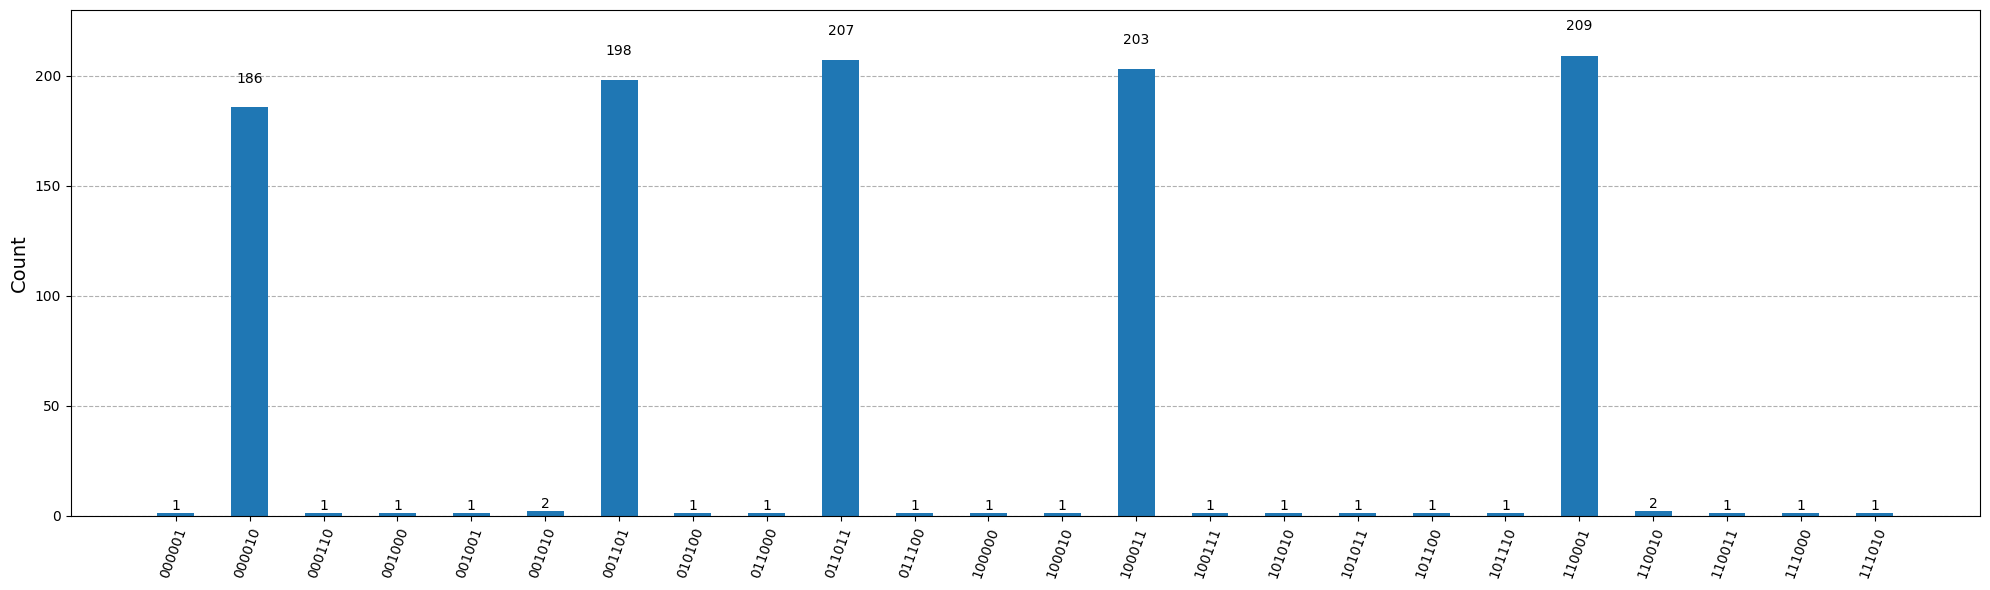

In [838]:
qc_compiled = transpile(quantum_circuit, backend)
job_sim = backend.run(qc_compiled, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)

# print the marked values in big-endian format (leftmost is qubit 0) / same format as in the histogram
print("Marked values:", sorted(
    [f"|{format(x, f'0{N_QUBITS}b')[::-1]}⟩" for x in MARKED_LIST]
))
# Plot the result
_ = plot_histogram(counts, figsize=(20, 6))